# Parameter Tuning Tutorial    

<b> Objective:</b> 
This tutorial covers how to perform hyperparameter tuning on a random forest model using sklearn's GridSearchCV and RandomSearchCV. 

 **Brief Overview of Random Forests from** [TowardDataScience](https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76): Click on hyperlink to learn more.
> A random forest is a model made up of many decision trees. Rather than just simply averaging the prediction of trees (which we could call a “forest”), this model uses two key concepts that gives it the name random:
1. Random sampling of training data points when building trees
2. Random subsets of features considered when splitting nodes

**The Dataset**
The random forest model will be trained to recognize handwritten digits from the MNIST database. Each greyscale image is 28 x 28, representing the digits 0-9, and consists of 60,000 training images and 10,000 test images. To reduce computational time, this tutorial uses only a subset of the full dataset (10,000 train images and 1,000 test images). Assuming a Gaussian distribution for the MNIST dataset, the dataset is also standardized such that each feature has a mean of 0 and a standard deviation of 1.

# Hyperparameter Tuning Methods

  The base random forest model which will be tuned is initialized with 500 estimators and a random state of 42. Using five-fold cross validation, this base model has an mean accuracy score of 0.89 with a standard deviation of 0.02.  
  
**GridSearchCV**

This function allows you to run an exhaustive search on all of the possible parameters and parameter combinations as inputs to the Random Forest model and returns the parameters that gives the best performance. 

**RandomizedSearchCV**

Instead of trying out an exhaustive list of parameters and parameter combinations like GridSearchCV, only a fixed number of parameter combinations is sampled from the full sample space containing all possible combinations of parameter settings. The number of parameter settings that are tried is given by n_iter. 


# Code 


In [1]:
from sklearn.datasets import fetch_openml
# Load data from https://www.openml.org/d/554
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load the dataset
images, labels = fetch_openml('mnist_784', version=1, return_X_y=True)

# Check dimensions of the data
print(images.shape)

# Pick the fifth image from the dataset (it's a 9)
i = 4
image, label = images[i], labels[i]

# Splitting the data into training and testing samples
from sklearn.model_selection import train_test_split
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, train_size = 10000,
                                                                        test_size = 1000, random_state = 42)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
images_train = scaler.fit_transform(images_train)
images_test = scaler.transform(images_test)

(70000, 784)


In [20]:
# Set up a random forest classifier with 500 trees, leaving other parameters as default parameters.
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Set up classifier and train classifer
clf = RandomForestClassifier(n_estimators=500, random_state = 42)
print(clf)
clf.fit(images_train, labels_train)

# Test classifier
predicted_labels = clf.predict(images_test)

# Evaluate classifier
print("Accuracy: ", accuracy_score(labels_test, predicted_labels))

# Using cross validation to evaluate performance. Compute mean score and 95% interval of score estimate
scores = cross_val_score(clf, images_test, labels_test, cv=5, scoring='accuracy')
print(scores)
print("Cross-Validation (CV=5) Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Accuracy:  0.954
[0.91133005 0.89108911 0.90049751 0.89393939 0.87755102]
Cross-Validation (CV=5) Accuracy: 0.89 (+/- 0.02)
CPU times: user 25.3 s, sys: 258 ms, total: 25.6 s
Wall time: 25.7 s


In [97]:
# Varying Number of Features

%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Variable to store the accuracies of each random forest classifier with varying number of features
accuracies = []
# Number of features to perform a hyperparameter sweep
features = np.logspace(2.0, 10.0, num=20, base=2.0, endpoint = False, dtype = int)

# Number of experiments to run for each feature value
num_trials = 10

trial_scores = []
mean_scores = []
std_scores = []

for feature in features:
    
    for t in range(num_trials):
        clf = RandomForestClassifier(n_estimators=500, max_features = feature, max_depth = 5, n_jobs = -2)
        clf.fit(images_train, labels_train)

        # Test classifier
        predicted_labels = clf.predict(images_test)

        # Evaluate classifier
        score = accuracy_score(labels_test, predicted_labels)
    
        if t == 0:
            trial_scores = []
            trial_scores.append(score)
        elif t == 9:
            trial_scores.append(score)
            mean = np.mean(trial_scores)
            std_dev = np.std(trial_scores)
            mean_scores.append(mean)
            std_scores.append(std_dev)
        else: 
            trial_scores.append(score)

CPU times: user 5h 13min 13s, sys: 2min 44s, total: 5h 15min 57s
Wall time: 34min 31s


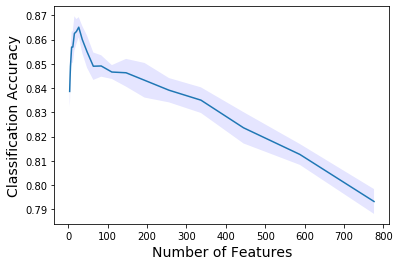

In [99]:
fig = plt.figure()
ax = plt.axes()
ax.plot(features,mean_scores);
ub0 = np.asarray(mean_scores) + 2*np.asarray(std_scores)
lb0 = np.asarray(mean_scores) - 2*np.asarray(std_scores)
ax.fill_between(features, ub0, lb0, facecolor='blue', alpha=0.1)
ax.set_xlabel('Number of Features', fontsize=14)
ax.set_ylabel('Classification Accuracy', fontsize=14)
fig.savefig('varying_features_plot.png', dpi=300, bbox_inches='tight')

In [100]:
# Varying maximum depth of trees.

%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Variable to store the accuracies of each random forest classifier with varying number of depths
accuracies = []
# Number of depths to perform a hyperparameter sweep
depths = np.logspace(2.0, 8.0, num = 10, base=2.0, endpoint = False, dtype = int)

# Number of experiments to run for each depth value
num_trials = 10

trial_scores = []
mean_scores = []
std_scores = []

for depth in depths:
    
    for t in range(num_trials):
        clf = RandomForestClassifier(n_estimators=500, max_depth = depth)
        clf.fit(images_train, labels_train)

        # Test classifier
        predicted_labels = clf.predict(images_test)

        # Evaluate classifier
        score = accuracy_score(labels_test, predicted_labels)
        
        if t == 0:
            trial_scores = []
            trial_scores.append(score)
        elif t == 9:
            trial_scores.append(score)
            mean = np.mean(trial_scores)
            std_dev = np.std(trial_scores)
            mean_scores.append(mean)
            std_scores.append(std_dev)
        else: 
            trial_scores.append(score)

CPU times: user 26min 37s, sys: 10.8 s, total: 26min 48s
Wall time: 26min 53s


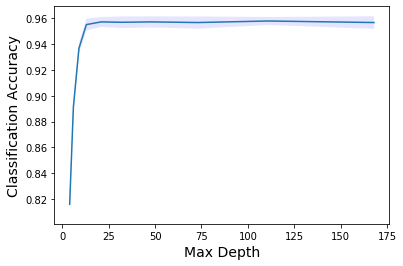

In [103]:
fig = plt.figure()
ax = plt.axes()
ax.plot(depths,mean_scores);
ub0 = np.asarray(mean_scores) + 2*np.asarray(std_scores)
lb0 = np.asarray(mean_scores) - 2*np.asarray(std_scores)
ax.fill_between(depths, ub0, lb0, facecolor='blue', alpha=0.1)
ax.set_xlabel('Max Depth', fontsize=14)
ax.set_ylabel('Classification Accuracy', fontsize=14)
fig.savefig('varying_depths_plot.png', dpi=300, bbox_inches='tight')

In [13]:
# Grid Search Tuning

%%time
from sklearn.model_selection import GridSearchCV

# Set up classifier
clf = RandomForestClassifier(n_estimators = 500, random_state=42)

# Set up combinations of paramters to tune
param_grid = { 
    'max_features': np.logspace(2.0, 10, num = 10, base=2.0, endpoint = False, dtype = int),
    'max_depth' : np.logspace(2.0, 8.0, num = 10, base=2.0, endpoint = False, dtype = int),
}

# Perform Grid Search Tuning
CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 3)
CV_clf.fit(images_train, labels_train)

print(CV_clf.best_params_)

CPU times: user 3h 27min 24s, sys: 40.9 s, total: 3h 28min 5s
Wall time: 3h 30min 5s


{'max_depth': 21, 'max_features': 21}

In [14]:
# Evalulate the performance Random Forest classifier using the best combination of parameters 
# found by GridSearchCV. 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Set up classifier and train classifer
clf = RandomForestClassifier(n_estimators=500, max_features = 21, max_depth = 21, random_state = 42)
print(clf)
clf.fit(images_train, labels_train)

# Test classifier
predicted_labels = clf.predict(images_test)

# Evaluate classifier
print("Accuracy: ", accuracy_score(labels_test, predicted_labels))

# Using cross validation to evaluate performance. Compute mean score and 95% interval of score estimate
scores = cross_val_score(clf, images_test, labels_test, cv=5, scoring='accuracy')
print(scores)
print("Cross-Validation (CV=5) Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=21, max_features=21, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Accuracy:  0.957
[0.90147783 0.88613861 0.89054726 0.87878788 0.89285714]
Cross-Validation (CV=5) Accuracy: 0.89 (+/- 0.01)


In [15]:
# Random Search Tuning

%%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Set up classifier
clf = RandomForestClassifier(n_estimators = 500, random_state=42)

# Set up combinations of paramters to tune
param_grid = { 
    'max_features': np.logspace(2.0, 10, num= 10, base=2.0, endpoint = False, dtype = int),
    'max_depth' : np.logspace(2.0, 8.0, num = 10, base=2.0, endpoint = False, dtype = int),
}

CV_clf = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_iter = 50,
                            cv = 3, random_state=42)

CV_clf.fit(images_train, labels_train)

CV_clf.best_params_

CPU times: user 1h 28min 38s, sys: 23.5 s, total: 1h 29min 2s
Wall time: 1h 29min 25s


{'max_features': 21, 'max_depth': 111}

In [17]:
# Evalulate the performance Random Forest classifier using the best combination 
# of parameters found by RandomizedSearchCV. 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Set up classifier and train classifer
clf = RandomForestClassifier(n_estimators=500, max_features = 21, max_depth = 111, random_state = 42)
print(clf)
clf.fit(images_train, labels_train)

# Test classifier
predicted_labels = clf.predict(images_test)

# Evaluate classifier
print("Accuracy: ", accuracy_score(labels_test, predicted_labels))

# Using cross validation to evaluate performance. Compute mean score and 95% interval of score estimate
scores = cross_val_score(clf, images_test, labels_test, cv=5, scoring='accuracy')
print(scores)
print("Cross-Validation (CV=5) Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=111, max_features=21, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Accuracy:  0.957
[0.90147783 0.88613861 0.89054726 0.87878788 0.89285714]
Cross-Validation (CV=5) Accuracy: 0.89 (+/- 0.01)


In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
import numpy as np

features = np.logspace(2.0, 10, num= 10, base=2.0, endpoint = False, dtype = int)
depth =  np.logspace(2.0, 8.0, num = 10, base=2.0, endpoint = False, dtype = int)
grid = {'n_features': features, 'n_depth': depth}
acc_scores = []

num_trials = 5
trial_score = 0
for count, params in enumerate(ParameterGrid(grid)):
    for t in range(num_trials):

        # Obtain similarity matrix from USPORF classifier
        clf = RandomForestClassifier(n_estimators = 500,
                                       max_features = params['n_features'],
                                       max_depth = params['n_depth'],
                                       random_state=42,
                                       n_jobs = -2)

        clf.fit(images_train, labels_train)
        
        # Test classifier
        predicted_labels = clf.predict(images_test)

        # Evaluate classifier
        score = accuracy_score(labels_test, predicted_labels)

        # Save tree information and associated ARI score
        trial_score += score
        
    acc_scores.append(trial_score/num_trials)
    trial_score = 0

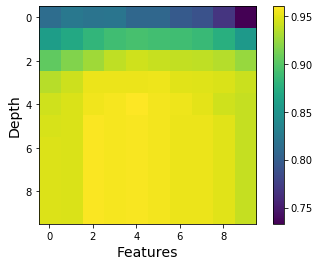

In [108]:
acc = np.asarray(acc_scores).reshape(10,10)
plt.imshow(acc)
plt.colorbar()
plt.xlabel('Features', fontsize=14)
plt.ylabel('Depth', fontsize=14)
plt.show()